In [1]:
import os
import os.path
from pathlib import Path
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir('..')


In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime, date
parquet_files = []
start = "2012-12"
end = "2022-11"
fmt = "http://steam-bot.s3.amazonaws.com/public/market-archive/partition={partition}/part.0.parquet"
fmt_local = "./parquet/partition={partition}/part.0.parquet"
current_date = datetime.strptime(start, "%Y-%m").date()
end_date = datetime.strptime(end, "%Y-%m").date()
while current_date <= end_date:
    parquet_files.append((fmt.format(partition=current_date.strftime("%Y-%m")), fmt_local.format(partition=current_date.strftime("%Y-%m"))))
    new_year, new_month = current_date.year, current_date.month
    new_month += 1
    if new_month >= 13:
        new_year += 1
        new_month = 1
    current_date = date(year=new_year, month=new_month, day=1)


In [4]:
import aiohttp        
import aiofiles

async def _download_file(url, path: Path):
    if path.exists():
        return
    print(f"Downloading to '{path}' ...")
    async with aiohttp.ClientSession() as session:
        path.parent.mkdir(parents=True, exist_ok=True)
        async with session.get(url) as resp:
            if resp.status == 200:
                f = await aiofiles.open(path, mode='wb')
                await f.write(await resp.read())
                await f.close()

for url, path in parquet_files:
    await _download_file(url, Path(path))

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('myAppName') \
    .config("spark.memory.fraction", 0.8) \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "16g")\
    .config("spark.sql.shuffle.partitions" , "800") \
    .config("spark.memory.offHeap.enabled",'true')\
    .config("spark.memory.offHeap.size","16g")\
    .getOrCreate()

In [6]:
import pyspark.sql.functions as func
from pyspark.sql.types import DecimalType

In [7]:
parquet_files = []
for root, dirs, files in os.walk('parquet/'):
    for file in files:
        if file.endswith(".parquet"):
            parquet_files.append(f"{root}/{file}")
df = spark.read.parquet(*parquet_files)

In [8]:
df.count()

215911515

In [9]:
df.printSchema()

root
 |-- index: long (nullable = true)
 |-- app_id: long (nullable = true)
 |-- market_hash_name: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- price: double (nullable = true)
 |-- amount: long (nullable = true)



In [10]:
df = df.withColumn("timestamp",func.to_timestamp("timestamp"))

In [11]:
df.printSchema()

root
 |-- index: long (nullable = true)
 |-- app_id: long (nullable = true)
 |-- market_hash_name: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- amount: long (nullable = true)



In [12]:
df.show()

+-----+-------+----------------+-------------------+-----+------+
|index| app_id|market_hash_name|          timestamp|price|amount|
+-----+-------+----------------+-------------------+-----+------+
|    0|1949740|      AL48 Metal|2022-10-01 01:00:00| 0.03|    36|
|    1|1949740|      AL48 Metal|2022-10-02 01:00:00| 0.03|    12|
|    2|1949740|      AL48 Metal|2022-10-03 01:00:00| 0.03|    10|
|    3|1949740|      AL48 Metal|2022-10-04 01:00:00| 0.03|     6|
|    4|1949740|      AL48 Metal|2022-10-05 01:00:00| 0.03|    59|
|    5|1949740|      AL48 Metal|2022-10-06 01:00:00| 0.03|    10|
|    6|1949740|      AL48 Metal|2022-10-07 01:00:00| 0.03|     9|
|    7|1949740|      AL48 Metal|2022-10-08 01:00:00| 0.03|    14|
|    8|1949740|      AL48 Metal|2022-10-09 01:00:00| 0.03|    22|
|    9|1949740|      AL48 Metal|2022-10-10 01:00:00| 0.03|    10|
|   10|1949740|      AL48 Metal|2022-10-11 01:00:00| 0.03|    25|
|   11|1949740|      AL48 Metal|2022-10-12 01:00:00| 0.03|    11|
|   12|194

In [13]:
# df.createOrReplaceTempView("history")
# parkSQL = spark.sql("select sum(price * amount) AS Volume, sum(amount) as Total_amount from history where app_id = 730")
# parkSQL.show()

In [14]:
df.groupby("market_hash_name").sum("amount").sort("sum(amount)", ascending=False).show()

+--------------------+-----------+
|    market_hash_name|sum(amount)|
+--------------------+-----------+
|         Clutch Case|  134768975|
|        Gamma 2 Case|  121917096|
|       Chroma 3 Case|  101683679|
|    Danger Zone Case|   96496214|
|Operation Breakou...|   90903986|
|       Chroma 2 Case|   88739813|
|     Spectrum 2 Case|   85373019|
|Operation Phoenix...|   75896023|
|          Glove Case|   74989313|
|       Prisma 2 Case|   73218680|
|         Prisma Case|   71152439|
|       Fracture Case|   61277159|
|          Gamma Case|   58658775|
|       Spectrum Case|   57619436|
|       Falchion Case|   50606608|
|        Horizon Case|   45356078|
|         Shadow Case|   41687378|
|         Chroma Case|   41092006|
|           CS20 Case|   37828820|
|       Revolver Case|   37827226|
+--------------------+-----------+
only showing top 20 rows



In [15]:
df \
  .groupby("market_hash_name") \
  .agg( \
    func.sum(df.amount).alias("total_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.sum(df.price * df.amount).cast(DecimalType(38, 2)).alias("total_volume") \
  ) \
  .sort("total_volume", ascending=False) \
  .show()

+--------------------+------------+---------+------------+
|    market_hash_name|total_amount|avg_price|total_volume|
+--------------------+------------+---------+------------+
|Mann Co. Supply C...|    28881345|     2.31| 66598234.33|
|AK-47 | Redline (...|     5084883|    11.68| 40551338.78|
|Operation Breakou...|    90903986|     1.39| 29011727.90|
|          Glove Case|    74989313|      1.4| 27361058.27|
|         Clutch Case|   134768975|     0.22| 25192158.63|
|Operation Broken ...|    29554806|     1.52| 23360862.09|
|AWP | Asiimov (Ba...|      760938|    43.27| 22938967.61|
|GAMESCOM INVITATI...|     6571954|     0.86| 20788090.66|
|Dreams & Nightmar...|    18597059|     0.82| 20697226.15|
|★ M9 Bayonet | Do...|       59812|   410.87| 20595456.71|
|       Fracture Case|    61277159|     0.27| 20288487.37|
|★ Bayonet | Doppl...|       69859|   334.37| 19631959.83|
|     Dragonclaw Hook|       73520|   317.35| 19416592.73|
|       Chroma 2 Case|    88739813|     0.34| 18816198.5

In [38]:
df \
  .groupby("app_id", "market_hash_name") \
  .agg( \
    func.sum(df.amount).alias("total_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.round(func.min(df.price), 2).alias("min_price"), \
    func.round(func.max(df.price), 2).alias("max_price"), \
    func.sum(df.price * df.amount).cast(DecimalType(38, 2)).alias("total_volume") \
  ) \
  .sort("total_volume", ascending=False) \
  .show(50, False)

+------+----------------------------------------+------------+---------+---------+---------+------------+
|app_id|market_hash_name                        |total_amount|avg_price|min_price|max_price|total_volume|
+------+----------------------------------------+------------+---------+---------+---------+------------+
|440   |Mann Co. Supply Crate Key               |28881345    |2.31     |1.53     |2.55     |66598234.33 |
|730   |AK-47 | Redline (Field-Tested)          |5084883     |11.68    |4.24     |42.85    |40551338.78 |
|730   |Operation Breakout Weapon Case          |90903986    |1.39     |0.03     |4.72     |29011727.90 |
|730   |Glove Case                              |74989313    |1.4      |0.03     |8.16     |27361058.27 |
|730   |Clutch Case                             |134768975   |0.22     |0.03     |8.94     |25192158.63 |
|730   |Operation Broken Fang Case              |29554806    |1.52     |0.32     |2.23     |23360862.09 |
|730   |AWP | Asiimov (Battle-Scarred)        

Compute market volume for each app

In [40]:
df \
  .groupby("app_id") \
  .agg( \
    func.sum(df.amount).alias("total_sold_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.sum(df.price * df.amount).cast(DecimalType(38, 2)).alias("total_sold_volume"), \
    func.min(df.price).cast(DecimalType(38, 2)).alias("min_price"), \
    func.max(df.price).cast(DecimalType(38, 2)).alias("max_price"), \
    func.count_distinct(df.market_hash_name).alias("market_items_amount") \
  ) \
  .sort("total_sold_volume", ascending=False) \
  .show()

+------+-----------------+---------+-----------------+---------+---------+-------------------+
|app_id|total_sold_amount|avg_price|total_sold_volume|min_price|max_price|market_items_amount|
+------+-----------------+---------+-----------------+---------+---------+-------------------+
|   730|       4269578286|    17.67|    4246101903.73|     0.03|  2008.57|              16036|
|   570|        931933185|     1.87|     888378452.53|     0.03|  1996.47|              28137|
|578080|        308682628|     5.52|     350514359.16|     0.03|  1946.11|                352|
|   440|        222003330|     4.88|     248950096.12|     0.03|  1805.22|              27709|
|   753|       2302457334|     0.14|     174936523.68|     0.03|   870.38|             202824|
|252490|         60584139|     3.71|     115806877.24|     0.03|  1800.00|               2744|
|232090|         79032867|     1.36|      11905712.10|     0.03|   466.06|               2456|
|218620|         48190750|     0.67|       7968977

Find all CS:GO knifes and gloves that has been sold by price lower than 10$

In [34]:
df \
  .filter(df.app_id == 730) \
  .filter(df.market_hash_name.startswith('★')) \
  .groupby("market_hash_name") \
  .agg( \
    func.sum(df.amount).alias("total_amount"), \
    func.round(func.avg(df.price), 2).alias("avg_price"), \
    func.min(df.price).cast(DecimalType(38, 2)).alias("min_price"), \
    func.max(df.price).cast(DecimalType(38, 2)).alias("max_price"), \
    func.count(func.when(df.price < 10, df.price)).alias("cheap_amount") \
  ) \
  .filter(func.col("cheap_amount") > 0) \
  .sort("cheap_amount", ascending=False) \
  .show(100000, False)

+------------------------------------------------------------+------------+---------+---------+---------+------------+
|market_hash_name                                            |total_amount|avg_price|min_price|max_price|cheap_amount|
+------------------------------------------------------------+------------+---------+---------+---------+------------+
|★ Flip Knife | Urban Masked (Well-Worn)                     |3966        |67.19    |0.53     |136.83   |6           |
|★ StatTrak™ Butterfly Knife | Boreal Forest (Field-Tested)  |3044        |188.47   |0.11     |690.00   |6           |
|★ StatTrak™ Bayonet | Stained (Well-Worn)                   |815         |136.39   |0.03     |280.12   |5           |
|★ Flip Knife | Case Hardened (Factory New)                  |962         |144.31   |0.03     |461.08   |5           |
|★ Shadow Daggers | Scorched (Well-Worn)                     |2693        |58.65    |0.43     |386.68   |5           |
|★ Gut Knife | Boreal Forest (Battle-Scarred)   

In [26]:
sum_df = df \
  .groupby("timestamp") \
  .agg( \
    func.sum(df.price * df.amount).alias("total_volume"), \
    func.sum(df.amount).alias("total_amount") \
  ) \
  .orderBy("timestamp")

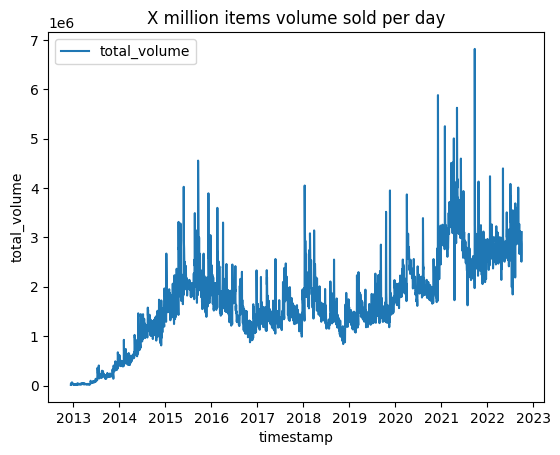

In [24]:
plot_end = datetime(2022, 10, 1) 

y_ans_val = [val.total_volume for val in sum_df.filter(sum_df.timestamp < plot_end).select('total_volume').collect()]
x_ts = [val.timestamp for val in sum_df.filter(sum_df.timestamp < plot_end).select('timestamp').collect()]

plt.plot(x_ts, y_ans_val)

plt.ylabel('total_volume')
plt.xlabel('timestamp')
plt.title('X million items volume sold per day')
plt.legend(['total_volume'], loc='upper left')

plt.show()

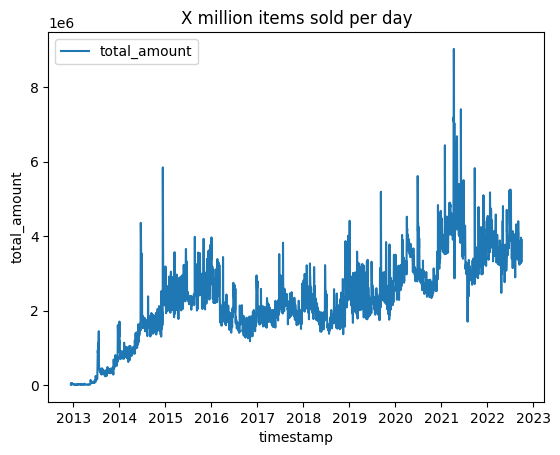

In [27]:
y_ans_val = [val.total_amount for val in sum_df.filter(sum_df.timestamp < plot_end).select('total_amount').collect()]
x_ts = [val.timestamp for val in sum_df.filter(sum_df.timestamp < plot_end).select('timestamp').collect()]

plt.plot(x_ts, y_ans_val)

plt.ylabel('total_amount')
plt.xlabel('timestamp')
plt.title('X million items sold per day')
plt.legend(['total_amount'], loc='upper left')

plt.show()